### 加载数据集

In [1]:
import sys
sys.path.append('../../')


from datasets.datasets import DatasetManager

dataset_manager = DatasetManager(batch_size=2048)
# train_loader, test_loader = dataset_manager.cifar_dataset()
train_loader, test_loader = dataset_manager.mnist_dataset()

Using device: cuda:7
CIFAR-10 path: /home/jzgrp/huiwang/mio/Code/KAN/datasets/CIFAR10
MNIST path: /home/jzgrp/huiwang/mio/Code/KAN/datasets/mnist


### PCA

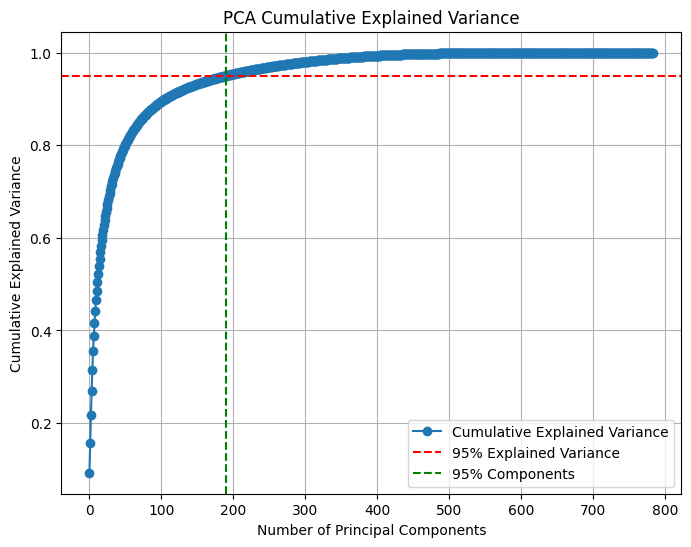

In [94]:
from sklearn.decomposition import PCA
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# 定义一个新的 Dataset 包装 PCA 处理后的数据
class PCADataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]
    
# 绘制 PCA 累积方差曲线
def plot_pca_variance(train_loader):
    # 提取训练数据并展平
    train_data = []
    for data, _ in train_loader:
        train_data.append(data.view(data.size(0), -1).numpy())
    train_data = np.vstack(train_data)

    # 计算 PCA
    pca = PCA()
    pca.fit(train_data)
    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

    # 绘图
    plt.figure(figsize=(8, 6))
    plt.plot(explained_variance_ratio, marker='o', linestyle='-', label='Cumulative Explained Variance')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
    plt.axvline(x=np.argmax(explained_variance_ratio >= 0.95), color='g', linestyle='--', label='95% Components')
    plt.title('PCA Cumulative Explained Variance')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.grid(True)
    plt.show()

# 添加 PCA 处理逻辑
def apply_pca(train_loader, test_loader, n_components):
    # 提取数据和标签
    train_data = []
    train_targets = []
    for data, target in train_loader:
        train_data.append(data.view(data.size(0), -1).numpy())
        train_targets.append(target.numpy())
    train_data = np.vstack(train_data)
    train_targets = np.concatenate(train_targets)

    test_data = []
    test_targets = []
    for data, target in test_loader:
        test_data.append(data.view(data.size(0), -1).numpy())
        test_targets.append(target.numpy())
    test_data = np.vstack(test_data)
    test_targets = np.concatenate(test_targets)

    # 拟合 PCA
    pca = PCA(n_components=n_components)
    train_data_pca = pca.fit_transform(train_data)
    test_data_pca = pca.transform(test_data)

    # 包装为 DataLoader
    train_pca_loader = DataLoader(PCADataset(train_data_pca, train_targets), batch_size=train_loader.batch_size, shuffle=True)
    test_pca_loader = DataLoader(PCADataset(test_data_pca, test_targets), batch_size=test_loader.batch_size, shuffle=False)

    return train_pca_loader, test_pca_loader

# 在主程序中调用
train_loader, test_loader = dataset_manager.mnist_dataset()

# 绘制 PCA 累积方差曲线
plot_pca_variance(train_loader)

train_pca_loader, test_pca_loader = apply_pca(train_loader, test_loader, n_components=200)

train_loader, test_loader = train_pca_loader, test_pca_loader

### LDA

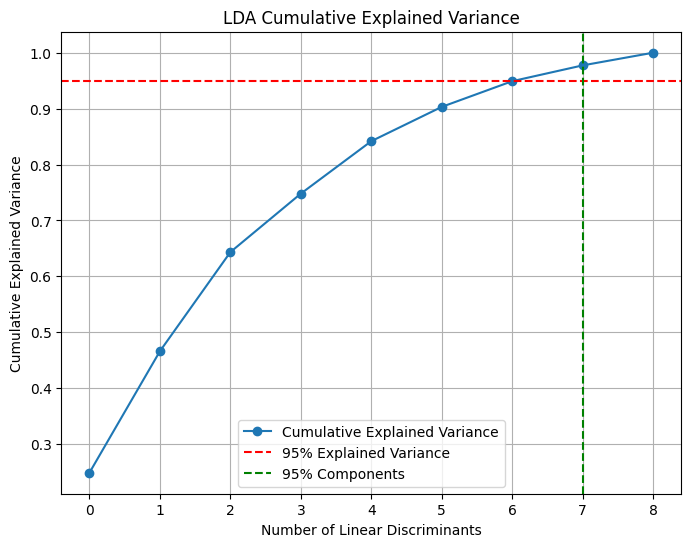

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import torch
from torch.utils.data import Dataset, DataLoader

# 定义一个新的 Dataset 包装 LDA 处理后的数据
class LDADataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# 绘制 LDA 累积方差曲线
def plot_lda_variance(train_loader):
    # 提取训练数据和标签并展平
    train_data = []
    train_targets = []
    for data, target in train_loader:
        train_data.append(data.view(data.size(0), -1).numpy())
        train_targets.append(target.numpy())
    train_data = np.vstack(train_data)
    train_targets = np.concatenate(train_targets)

    # 计算 LDA
    lda = LDA()
    lda.fit(train_data, train_targets)
    explained_variance_ratio = np.cumsum(lda.explained_variance_ratio_)

    # 绘图
    plt.figure(figsize=(8, 6))
    plt.plot(explained_variance_ratio, marker='o', linestyle='-', label='Cumulative Explained Variance')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
    plt.axvline(x=np.argmax(explained_variance_ratio >= 0.95), color='g', linestyle='--', label='95% Components')
    plt.title('LDA Cumulative Explained Variance')
    plt.xlabel('Number of Linear Discriminants')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.grid(True)
    plt.show()

# 添加 LDA 处理逻辑
def apply_lda(train_loader, test_loader, n_components):
    # 提取训练数据和标签
    train_data = []
    train_targets = []
    for data, target in train_loader:
        train_data.append(data.view(data.size(0), -1).numpy())
        train_targets.append(target.numpy())
    train_data = np.vstack(train_data)
    train_targets = np.concatenate(train_targets)

    test_data = []
    test_targets = []
    for data, target in test_loader:
        test_data.append(data.view(data.size(0), -1).numpy())
        test_targets.append(target.numpy())
    test_data = np.vstack(test_data)
    test_targets = np.concatenate(test_targets)

    # 拟合 LDA
    lda = LDA(n_components=n_components)
    train_data_lda = lda.fit_transform(train_data, train_targets)
    test_data_lda = lda.transform(test_data)

    # 包装为 DataLoader
    train_lda_loader = DataLoader(LDADataset(train_data_lda, train_targets), batch_size=train_loader.batch_size, shuffle=True)
    test_lda_loader = DataLoader(LDADataset(test_data_lda, test_targets), batch_size=test_loader.batch_size, shuffle=False)

    return train_lda_loader, test_lda_loader

train_loader, test_loader = dataset_manager.mnist_dataset()

# 绘制 LDA 累积方差曲线
plot_lda_variance(train_loader)

# 使用前 9 个线性判别向量（适合 MNIST 10 个类别）
train_lda_loader, test_lda_loader = apply_lda(train_loader, test_loader, n_components=9)

train_loader, test_loader = train_lda_loader, test_lda_loader



### SVD

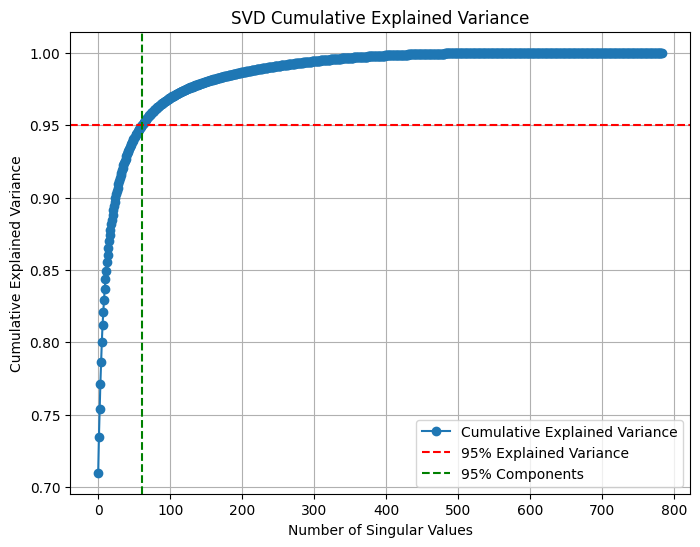

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
import torch
from torch.utils.data import Dataset, DataLoader

# 定义一个新的 Dataset 包装 SVD 处理后的数据
class SVDDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# 绘制 SVD 累积奇异值曲线
def plot_svd_variance(train_loader):
    # 提取训练数据并展平
    train_data = []
    for data, _ in train_loader:
        train_data.append(data.view(data.size(0), -1).numpy())
    train_data = np.vstack(train_data)

    # 计算 SVD
    U, Sigma, VT = randomized_svd(train_data, n_components=min(train_data.shape))
    explained_variance_ratio = np.cumsum(Sigma**2) / np.sum(Sigma**2)

    # 绘图
    plt.figure(figsize=(8, 6))
    plt.plot(explained_variance_ratio, marker='o', linestyle='-', label='Cumulative Explained Variance')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
    plt.axvline(x=np.argmax(explained_variance_ratio >= 0.95), color='g', linestyle='--', label='95% Components')
    plt.title('SVD Cumulative Explained Variance')
    plt.xlabel('Number of Singular Values')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.grid(True)
    plt.show()

# 添加 SVD 处理逻辑
def apply_svd(train_loader, test_loader, n_components):
    # 提取数据和标签
    train_data = []
    train_targets = []
    for data, target in train_loader:
        train_data.append(data.view(data.size(0), -1).numpy())
        train_targets.append(target.numpy())
    train_data = np.vstack(train_data)
    train_targets = np.concatenate(train_targets)

    test_data = []
    test_targets = []
    for data, target in test_loader:
        test_data.append(data.view(data.size(0), -1).numpy())
        test_targets.append(target.numpy())
    test_data = np.vstack(test_data)
    test_targets = np.concatenate(test_targets)

    # 计算 SVD 并截取前 n_components 个奇异值
    U, Sigma, VT = randomized_svd(train_data, n_components=n_components)
    train_data_svd = np.dot(U, np.diag(Sigma))

    U_test, Sigma_test, VT_test = randomized_svd(test_data, n_components=n_components)
    test_data_svd = np.dot(U_test, np.diag(Sigma_test))

    # 包装为 DataLoader
    train_svd_loader = DataLoader(SVDDataset(train_data_svd, train_targets), batch_size=train_loader.batch_size, shuffle=True)
    test_svd_loader = DataLoader(SVDDataset(test_data_svd, test_targets), batch_size=test_loader.batch_size, shuffle=False)

    return train_svd_loader, test_svd_loader

# 主程序
train_loader, test_loader = dataset_manager.mnist_dataset()

# 绘制 SVD 累积奇异值曲线
plot_svd_variance(train_loader)

# 使用 64 个奇异值进行 SVD 处理
train_svd_loader, test_svd_loader = apply_svd(train_loader, test_loader, n_components=64)

train_loader, test_loader = train_svd_loader, test_svd_loader



In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# from torchmetrics import Accuracy
import torch.nn.functional as F
from models.models import ModelManager 

model_manager = ModelManager()




class PCAKAN(nn.Module):
    def __init__(self):
        super(PCAKAN, self).__init__()
        # PCA 层：将输入从 28*28 降维到 128
        # self.pca = model_manager.PCALayer(input_dim=28*28, output_dim=128)
        # self.kan1 = model_manager.KANLinear(128, 32)
        self.kan2 = model_manager.KANLinear(64, 10)

    # def fit_pca(self, train_data):
    #     # 使用训练数据拟合 PCA 层
    #     self.pca.fit(train_data)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展开图像为一维向量
        # x = self.pca(x)  # PCA 降维
        # x = self.kan1(x)
        x = self.kan2(x)
        return x


class PCAMLP(nn.Module):
    def __init__(self):
        super(PCAMLP, self).__init__()
        # PCA 层：将输入从 28*28 降维到 128
        self.mlp1 = model_manager.MLPLinear(64, 10)

    # def fit_pca(self, train_data):
    #     # 使用训练数据拟合 PCA 层
    #     self.pca.fit(train_data)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展开图像为一维向量
        # x = self.pca(x)  # PCA 降维
        # x = self.kan1(x)
        x = self.mlp1(x)
        return x

class KANKAN(nn.Module):
    def __init__(self):
        super(KANKAN, self).__init__()
        self.kan1 = model_manager.KANLinear(28*28, 32)
        self.kan2 = model_manager.KANLinear(32, 10)
        # self.kan3 = model_manager.KANLinear(32, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展开图像为一维向量
        x = self.kan1(x)
        x = self.kan2(x)
        # x = self.kan3(x)
        return x

class KAN(nn.Module):
    def __init__(self):
        super(KAN, self).__init__()
        self.kan1 = model_manager.KANLinear(28*28, 10)
        # self.kan2 = model_manager.KANLinear(128, 32)
        # self.kan3 = model_manager.KANLinear(32, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展开图像为一维向量
        x = self.kan1(x)
        # x = self.kan2(x)
        # x = self.kan3(x)
        return x
    
class MLPMLP(nn.Module):
    def __init__(self):
        super(MLPMLP, self).__init__()
        self.mlp1 = model_manager.MLPLinear(28*28, 128)
        self.mlp2 = model_manager.MLPLinear(128, 10)
        # self.mlp3 = model_manager.MLPLinear(32, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展开图像为一维向量
        x = self.mlp1(x)
        x = self.mlp2(x)
        # x = self.mlp3(x)
        return x


class FourierKAN(nn.Module):
    def __init__(self):
        super(FourierKAN, self).__init__()
        self.fourierkan1 = model_manager.FourierKANLinear(28*28, 128)
        self.fourierkan2 = model_manager.FourierKANLinear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展开图像为一维向量
        x = self.fourierkan1(x)
        x = self.fourierkan2(x)
        return x

class ChebyKAN(nn.Module):
    def __init__(self):
        super(ChebyKAN, self).__init__()
        self.chebykan1 = model_manager.ChebyKANLinear(28*28, 128)
        self.chebykan2 = model_manager.ChebyKANLinear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展开图像为一维向量
        x = self.chebykan1(x)
        x = self.chebykan2(x)
        return x

class JacobiKAN(nn.Module):
    def __init__(self):
        super(JacobiKAN, self).__init__()
        self.jacobikan1 = model_manager.JacobiKANLinear(28*28, 128)
        self.jacobikan2 = model_manager.JacobiKANLinear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展开图像为一维向量
        x = self.jacobikan1(x)
        x = self.jacobikan2(x)
        return x

class TaylorKAN(nn.Module):
    def __init__(self):
        super(TaylorKAN, self).__init__()
        self.taylorkan1 = model_manager.TaylorKANLinear(28*28, 128)
        self.taylorkan2 = model_manager.TaylorKANLinear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展开图像为一维向量
        x = self.taylorkan1(x)
        x = self.taylorkan2(x)
        return x

class WaveletKAN(nn.Module):
    def __init__(self):
        super(WaveletKAN, self).__init__()
        self.waveletkan1 = model_manager.WaveletKANLinear(28*28, 128)
        self.waveletkan2 = model_manager.WaveletKANLinear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展开图像为一维向量
        x = self.waveletkan1(x)
        x = self.waveletkan2(x)
        return x

# class MLP(nn.Module):
#     def __init__(self):
#         super(MLP, self).__init__()
#         self.mlp1 = model_manager.MLPLinear(28*28, 128)
#         self.mlp2 = model_manager.MLPLinear(128, 32)
#         self.mlp3 = model_manager.MLPLinear(32, 10)

#     def forward(self, x):
#         x = x.view(x.size(0), -1)  # 展开图像为一维向量
#         x = self.mlp1(x)
#         x = self.mlp2(x)
#         x = self.mlp3(x)
#         return x
    
class CNNMLP(nn.Module):
    def __init__(self):
        super(CNNMLP, self).__init__()
        # 定义 CNN 层（适配 MNIST 数据集的输入 1 通道）
        self.conv1 = model_manager.ConvLinear(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = model_manager.ConvLinear(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # 定义全连接层（经过两次池化操作，特征图大小从 28x28 缩小为 7x7）
        self.fc1 = model_manager.MLPLinear(32 * 7 * 7, 128)  # 第一全连接层
        self.fc2 = model_manager.MLPLinear(128, 10)  # 第二全连接层（10 分类）
        
    def forward(self, x):
        # 卷积和池化
        x = self.conv1(x)
        x = self.conv2(x)
        # 展开为一维向量
        x = x.view(x.size(0), -1)
        # 全连接层
        x = self.fc1(x)
        x = self.fc2(x)
        return x

class CNNKAN(nn.Module):
    def __init__(self):
        super(CNNKAN, self).__init__()
        # 定义 CNN 层（适配 MNIST 数据集的输入 1 通道）
        self.conv1 = model_manager.ConvLinear(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = model_manager.ConvLinear(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # 定义全连接层（经过两次池化操作，特征图大小从 28x28 缩小为 7x7）
        self.fc1 = model_manager.KANLinear(32 * 7 * 7, 128)  # 第一全连接层
        self.fc2 = model_manager.KANLinear(128, 10)  # 第二全连接层（10 分类）
        
    def forward(self, x):
        # 卷积和池化
        x = self.conv1(x)
        x = self.conv2(x)
        # 展开为一维向量
        x = x.view(x.size(0), -1)
        # 全连接层
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    

class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.embedding = nn.Linear(28, 64)  # 将每行像素映射到嵌入维度 64
        # 定义 Transformer 层
        self.transformer1 = model_manager.TransformerLayer(embed_dim=64, num_heads=4, ff_dim=256)
        self.transformer2 = model_manager.TransformerLayer(embed_dim=64, num_heads=4, ff_dim=256)
        # 定义全连接层
        self.fc1 = model_manager.MLPLinear(64, 128)  # 第一全连接层
        self.fc2 = model_manager.MLPLinear(128, 10)  # 第二全连接层（10 分类）

    def forward(self, x, mask=None):
        # 将输入形状从 (batch_size, 1, 28, 28) 转为 (batch_size, 28, 28)
        x = x.squeeze(1)  # 去掉通道维度，变为 (batch_size, 28, 28)
        # 嵌入每行像素数据，形状变为 (28, batch_size, 64)
        x = self.embedding(x).permute(1, 0, 2)
        # 通过 Transformer 层
        x = self.transformer1(x, mask)
        x = self.transformer2(x, mask)
        # 平均池化以获取全局表示
        x = torch.mean(x, dim=0)  # 形状从 (seq_len, batch_size, embed_dim) -> (batch_size, embed_dim)
        # 全连接层
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
class MLPKANKAN(nn.Module):
    def __init__(self):
        super(MLPKANKAN, self).__init__()
        self.mlp1 = model_manager.MLPLinear(28*28, 128)
        self.kan1 = model_manager.KANLinear(128, 32)
        self.kan2 = model_manager.KANLinear(32, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展开图像为一维向量
        x = self.mlp1(x)
        x = self.kan1(x)
        x = self.kan2(x)
        return x
    
class MLPMLPKAN(nn.Module):
    def __init__(self):
        super(MLPMLPKAN, self).__init__()
        self.mlp1 = model_manager.MLPLinear(28*28, 128)
        self.mlp2 = model_manager.MLPLinear(128, 32)
        self.kan1 = model_manager.KANLinear(32, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展开图像为一维向量
        x = self.mlp1(x)
        x = self.mlp2(x)
        x = self.kan1(x)
        return x
    
class MLPKAN(nn.Module):
    def __init__(self):
        super(MLPKAN, self).__init__()
        self.mlp1 = model_manager.MLPLinear(28*28, 128)
        self.kan1 = model_manager.KANLinear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展开图像为一维向量
        x = self.mlp1(x)
        x = self.kan1(x)
        return x

In [4]:
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=7)

### 加载模型

In [ ]:
%%capture output0

from torchinfo import summary
import os


model_test = "SVDKAN64"
# model_test = "LassoKANKAN0.001"
# model_test = "MLPMLP"
# model = MLPMLP().to(device)  # Use 'cuda' for GPU
# model = FourierKAN().to(device)  # Use 'cuda' for GPU
# model = ChebyKAN().to(device)  # Use 'cuda' for GPU
# model = JacobiKAN().to(device)  # Use 'cuda' for GPU
# model = TaylorKAN().to(device)  # Use 'cuda' for GPU
# model = WaveletKAN().to(device)  # Use 'cuda' for GPU
# model = MLP().to(device)  # Use 'cuda' for GPU
# model = CNNKAN().to(device)  # Use 'cuda' for GPU
# model = CNNKAN().to(device)  # Use 'cuda' for GPU
# model = Transformer().to(device)  # Use 'cuda' for GPU
# model = PCAMLP().to(device)  # Use 'cuda' for GPU
model = PCAKAN().to(device)  # Use 'cuda' for GPU
# model = MLPMLPKAN().to(device)  # Use 'cuda' for GPU
# model = MLPKAN().to(device)  # Use 'cuda' for GPU



optimizer = optim.LBFGS(model.parameters(), lr=0.01)  # Reduced learning rate from 0.1 to 0.01

# 使用torchsummary输出模型结构
print(summary(model, input_size=(128, 1, 64, 1)))  # 输入特征为128维
# print(summary(model, input_size=(128, 1, 28, 28)))  # 输入特征为128维

if not os.path.exists(f"../../weights/{model_test}/"):
    os.makedirs(f"../../weights/{model_test}/")

with open(f"../../weights/{model_test}/{model_test}.log", "a") as log_file:
    log_file.write(output0.stdout)  # 写入日志文件

### 训练(利用预训练模型可只执行第一步然后跳去评估部分)

In [10]:
from weights.weights import WeightManager
weight_manager = WeightManager()

In [11]:
%%capture output1
import time

# Define the training loop
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            loss.backward()
            return loss
        data, target = data.to(device), target.to(device)
        optimizer.step(closure)
        if batch_idx % 10 == 0:
            loss = closure()
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def train_lasso(model, device, train_loader, optimizer, epoch, lambda_l1=0.01):
    model.train()  # 切换到训练模式
    for batch_idx, (data, target) in enumerate(train_loader):
        # 将数据和标签发送到指定设备
        data, target = data.to(device), target.to(device)

        # 定义闭包函数
        def closure():
            optimizer.zero_grad()  # 梯度清零
            output = model(data)  # 前向传播
            loss = nn.CrossEntropyLoss()(output, target)  # 基础交叉熵损失

            # 计算 L1 正则化项并加到损失中
            l1_regularization = 0
            for param in model.parameters():
                l1_regularization += torch.sum(torch.abs(param))
            loss += lambda_l1 * l1_regularization 

            loss.backward()  
            return loss

        optimizer.step(closure)

        if batch_idx % 10 == 0:
            loss = closure()  
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')


start_time = time.time()
for epoch in range(1, 6):
    # train_lasso(model, device, train_loader, optimizer, epoch, lambda_l1=0.001)
    train(model, device, train_loader, optimizer, epoch)
    weight_manager.save_model(model, optimizer, epoch=epoch, dir_name=model_test, file_name=f'{model_test}_{epoch}_checkpoint.pth')
end_time = time.time()
print(f"Training Time: {end_time - start_time}")

with open(f"../../weights/{model_test}/{model_test}.log", "a") as log_file:
    log_file.write(output1.stdout)  # 写入日志文件

### 评估

#### 读取所有权重文件测试

In [12]:
%%capture output2
# Evaluate the model
def evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss()(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')



pth_files = weight_manager.list_pth_files(dir_name=model_test)

if pth_files:
    print("Available .pth files:")
    for pth_file in pth_files:
        print(f"- {pth_file}")
    for pth_file in pth_files:
        model, optimizer, start_epoch = weight_manager.load_model(model, optimizer, dir_name=f'{model_test}', file_name=f"{pth_file}", device=device)
        
        start_time = time.time()
        evaluate(model, device, test_loader)
        end_time = time.time()
        print(f"Inference Time: {end_time - start_time}")

# Evaluate the trained model
# evaluate(model, device, test_loader)

with open(f"../../weights/{model_test}/{model_test}.log", "a") as log_file:
    log_file.write(output2.stdout)  # 写入日志文件